In [1]:
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"
!pip install kaggle

import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import matplotlib.pyplot as plt
import pandas as pd

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.16.0
    Uninstalling tf_keras-

In [2]:
tf.get_logger().setLevel('ERROR')

In [3]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
import re
import string
if not os.path.exists('IMDB Dataset.csv'):
    !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
    !unzip imdb-dataset-of-50k-movie-reviews.zip
df = pd.read_csv('IMDB Dataset.csv')

# Map 'positive' to 1 and 'negative' to 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})


# Define a function that cleans the text in a single step like removing html tags, converting to lowercase, removing punctuations, removing number's etc that are slightly less relevant and more efficient when embedding.
def clean_text(text):
    text = re.sub('<[^<]+?>', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    return text
df.loc[:, 'review'] = df['review'].apply(clean_text)

# Resetting Index to reflect Dropped Duplicates. else index would stay same from before causing KeyError when a dropped column is refered.
df = df.reset_index(drop=True)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 58%|██████████████████████▊                | 15.0M/25.7M [00:00<00:00, 144MB/s]
100%|███████████████████████████████████████| 25.7M/25.7M [00:00<00:00, 170MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [5]:

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.4, random_state=100, shuffle=False)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=100, shuffle=False)
print(train_df.shape, test_df.shape, val_df.shape)


(30000, 2) (10000, 2) (10000, 2)


In [6]:
# Convert DataFrames to TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df['review'].values, train_df['sentiment'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['review'].values, val_df['sentiment'].values))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['review'].values, test_df['sentiment'].values))

In [7]:
# Batching and prefetching
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [8]:
# BERT model and preprocessing
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'


In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')


In [10]:

# Model definition
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
print("Done")

Done


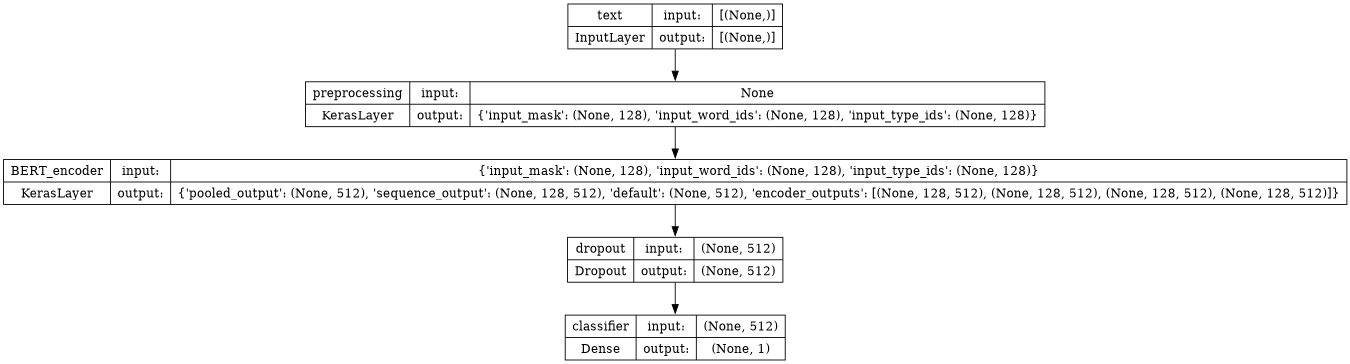

In [11]:
tf.keras.utils.plot_model(classifier_model, show_shapes=True, dpi=64)

In [12]:
# Loss, metrics, and optimizer
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [13]:
epochs = 5
steps_per_epoch = train_df.shape[0] // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [14]:
history = classifier_model.fit(
  x=train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
938/938 [==============================] - 3438s 4s/step - loss: 0.4518 - binary_accuracy: 0.7649 - val_loss: 0.3400 - val_binary_accuracy: 0.8522
Epoch 2/5
938/938 [==============================] - 3444s 4s/step - loss: 0.3063 - binary_accuracy: 0.8660 - val_loss: 0.3302 - val_binary_accuracy: 0.8581
Epoch 3/5
938/938 [==============================] - 3505s 4s/step - loss: 0.2301 - binary_accuracy: 0.9062 - val_loss: 0.3664 - val_binary_accuracy: 0.8600
Epoch 4/5
938/938 [==============================] - 3469s 4s/step - loss: 0.1776 - binary_accuracy: 0.9315 - val_loss: 0.4004 - val_binary_accuracy: 0.8700
Epoch 5/5
938/938 [==============================] - 3411s 4s/step - loss: 0.1391 - binary_accuracy: 0.9501 - val_loss: 0.4541 - val_binary_accuracy: 0.8705


In [15]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 250s 798ms/step - loss: 0.4607 - binary_accuracy: 0.8680
Loss: 0.4606824815273285
Accuracy: 0.8679999709129333


In [16]:
#Save the model as a pickle file
import pickle

with open('classifier_model.pkl', 'wb') as f:
    pickle.dump(classifier_model, f)

# Test the model with some movie reviews
test_reviews = [
    "This movie was absolutely fantastic! The acting was superb, the story was gripping, and the visuals were stunning. I highly recommend it.",
    "I found this movie to be quite mediocre. The plot was predictable, the characters were underdeveloped, and the pacing was slow. It's not the worst movie I've seen, but it's definitely not worth raving about.",
    "This movie was a complete waste of time. The acting was terrible, the dialogue was cringeworthy, and the special effects were laughable. I can't believe I paid money to see this."
]

# Preprocess the reviews
preprocessed_reviews = bert_preprocess_model(test_reviews)

# Make predictions
predictions = classifier_model.predict(preprocessed_reviews)

# Interpret the predictions
for i, prediction in enumerate(predictions):
    sentiment = "Positive" if prediction >= 0 else "Negative"
    print(f"Review {i+1}: {sentiment} (Score: {prediction[0]:.4f})")


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "text". You passed a data dictionary with keys ['input_mask', 'input_type_ids', 'input_word_ids']. Expected the following keys: ['text']
